In [2]:
# Load packages
import h5py
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from statannotations.Annotator import Annotator
import pickle as pkl
import sys
import os
sys.path.append('/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/')
import other_billeh_utils
from matplotlib.font_manager import FontProperties
import seaborn as sns
import pandas as pd

font = FontProperties()
font.set_weight('bold')

colors = ['darkviolet', 'lightseagreen', 'goldenrod']
labels = ['V1', 'LGN', 'LM']

## Spiking rate histogram for 1 trial

In [8]:
# First I try to plot a 2D histogram of the firing rate of each neurons and their mapped position in visual space

# Load data from one simulation
# Open the data
# Path to the data file
data_file = 'Data/simulation_data.hdf5'

# Open the file in read mode
file = h5py.File(data_file, 'r')

# Access the 'Data' group
data_group = file['Data']

# Initialize a dictionary to hold the data
data = {}

# Loop over the subgroups ('v1', 'lm', 'LGN')
for subgroup_name in data_group.keys():
    # Access the subgroup
    subgroup = data_group[subgroup_name]

    dataset = subgroup['6_5']
    
    # Convert the dataset to a numpy array and store it in the dictionary
    data[subgroup_name] = np.array(dataset)

# Close the file
file.close()


KeyboardInterrupt: 

In [ ]:
v1 = data['v1']
lm = data['lm']
LGN = data['LGN']
print(v1.shape)
print(lm.shape)
print(LGN.shape)

(100, 1400, 51978)
(100, 1400, 7414)
(100, 1400, 17400)


In [ ]:
# Compute the firing rate of each neuron in V1 in the regions where stimulus is presented
# Stimulus is presented from 100 to 350 ms, from 450 to 700 ms, from 800 to 1050 ms, and from 1150 to 1400 ms

# Define the time bins
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])

# Initialize a list to hold the firing rate of each neuron in each time bin
v1_firing_rate = []

# Loop over the time bins
for time_bin in time_bins:
    # Compute the firing rate of each neuron in V1 in the time bin
    firing_rate = np.mean(v1[:, time_bin[0]:time_bin[1]], axis=1)
    
    # Append the firing rate to the list
    v1_firing_rate.append(firing_rate)

# Convert the list to a numpy array
v1_firing_rate = np.array(v1_firing_rate)

# Compute the mean firing rate for each neuron in all time bins
v1_mean_firing_rate = np.mean(v1_firing_rate, axis=0)

ValueError: 'c' argument has 5197800 elements, which is inconsistent with 'x' and 'y' with size 51978.

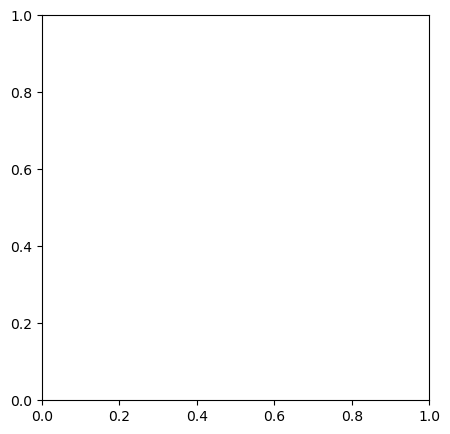

In [ ]:
# Obtain the position of each V1 neuron
import pickle as pkl
import sys
import os
sys.path.append('/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/')
import other_billeh_utils

# Load model
cache_path = '/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/.cache/lm_v1_network_v1_100000_lm_30000.pkl'
with open(cache_path, 'rb') as f:
    networks, lgn_inputs, bkg_inputs = pkl.load(f)

# # filter only network in the core (radius < 400 mm)
# selected_mask = other_billeh_utils.isolate_core_neurons(networks, radius = 400, data_dir = '/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
# core_network = network[selected_mask]

# in networks['v1'] 'x' and 'z' are the 2 radial coordinates, and y is the depth in the column which I don't need
v1_positions_x = np.array(networks['v1']['x'])
v1_positions_z = np.array(networks['v1']['z'])

# filter only core neurons that follow r = np.sqrt(x ** 2 + z ** 2) < 400
r = np.sqrt(v1_positions_x ** 2 + v1_positions_z ** 2)
selected_mask = r < 400
v1_positions_x_core = v1_positions_x[selected_mask]
v1_positions_z_core = v1_positions_z[selected_mask]

# # Plot the 2D histogram of the firing rate of each neuron in V1 and their position in visual space
plt.figure(figsize=(5, 5))
plt.scatter(v1_positions_x_core, v1_positions_z_core, c=v1_mean_firing_rate, cmap='Spectral', s=0.5)
plt.colorbar()
plt.xlabel('azimuth')
plt.ylabel('elevation')	
# put axis in same scale
plt.axis('equal')
plt.title('Firing rate of V1 neurons')
plt.show()

In [ ]:
# Now convert the scatter into a histogram where for each bin I compute the mean firing rate of the neurons in that bin
# Define the bins
from tqdm import tqdm
n_bins = 100
x_bins = np.linspace(-400, 400, n_bins)
z_bins = np.linspace(-400, 400, n_bins)

# Initialize a 2D array to hold the mean firing rate of the neurons in each bin
v1_firing_rate_bins = np.zeros((len(x_bins)-1, len(z_bins)-1))

# Loop over the bins
for i in tqdm(range(len(x_bins)-1)):
    for j in range(len(z_bins)-1):
        # Find the indices of the neurons in the bin
        indices = np.where((v1_positions_x_core >= x_bins[i]) & (v1_positions_x_core < x_bins[i+1]) & (v1_positions_z_core >= z_bins[j]) & (v1_positions_z_core < z_bins[j+1]))[0]
        
        # Compute the mean firing rate of the neurons in the bin
        if len(indices) > 0:
            v1_firing_rate_bins[i, j] = np.median(v1_mean_firing_rate[0][indices])

100%|██████████| 99/99 [00:01<00:00, 89.69it/s] 


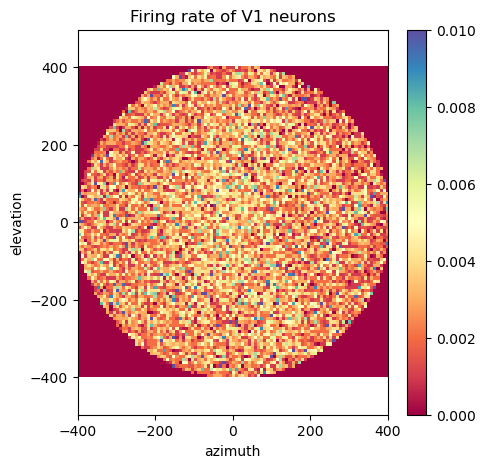

In [ ]:
# Plot the 2D histogram
plt.figure(figsize=(5, 5))
plt.imshow(v1_firing_rate_bins.T, extent=[-400, 400, -400, 400], origin='lower', cmap='Spectral', vmin=0, vmax=0.01)
plt.colorbar()
plt.xlabel('azimuth')
plt.ylabel('elevation')
plt.xlim(-400, 400)
plt.title('Firing rate of V1 neurons')
plt.axis('equal')
plt.show()

In [ ]:
# Now do it again but selecting only neurons from a given type

# Create the neuron types mask
# obtain the neuron type of each neuron 
new_pop_names = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=51978, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
cell_types_v1 = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]

unique_cell_types = list(set(cell_types_v1))
unique_cell_types = sorted(unique_cell_types)

layer_mask_v1_types = [[cell_type == unique_cell_types[i] for cell_type in cell_types_v1] for i in range(len(unique_cell_types))]

# Apply the mask to mean firing rates AND positions
# Select the neuron type to filter
t = 5
type = unique_cell_types[t]
print("You have selected the type: ", type)

# Apply the mask to the mean firing rates
v1_mean_firing_rate_type = v1_mean_firing_rate[0][layer_mask_v1_types[t]]

# Apply the mask to the positions
v1_positions_x_core_type = v1_positions_x_core[layer_mask_v1_types[t]]
v1_positions_z_core_type = v1_positions_z_core[layer_mask_v1_types[t]]

You have selected the type:  L4 Exc


In [ ]:
n_bins = 75
x_bins = np.linspace(-400, 400, n_bins)
z_bins = np.linspace(-400, 400, n_bins)

# Initialize a 2D array to hold the mean firing rate of the neurons in each bin
v1_firing_rate_bins = np.zeros((len(x_bins)-1, len(z_bins)-1))

# Loop over the bins
for i in tqdm(range(len(x_bins)-1)):
    for j in range(len(z_bins)-1):
        # Find the indices of the neurons in the bin
        indices = np.where((v1_positions_x_core_type >= x_bins[i]) & (v1_positions_x_core_type < x_bins[i+1]) & (v1_positions_z_core_type >= z_bins[j]) & (v1_positions_z_core_type < z_bins[j+1]))[0]
        
        # Compute the mean firing rate of the neurons in the bin
        if len(indices) > 0:
            v1_firing_rate_bins[i, j] = np.median(v1_mean_firing_rate_type[indices])

100%|██████████| 74/74 [00:00<00:00, 176.68it/s]


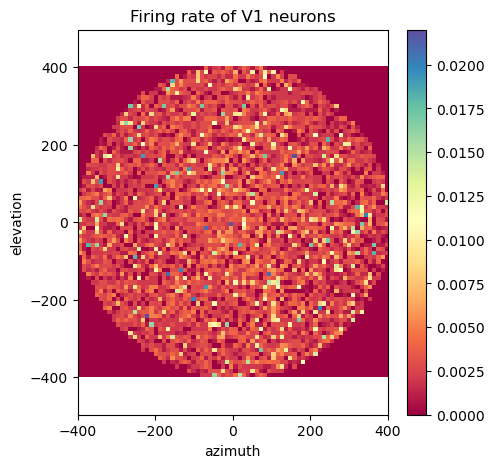

In [ ]:
# Plot the 2D histogram
plt.figure(figsize=(5, 5))
plt.imshow(v1_firing_rate_bins.T, extent=[-400, 400, -400, 400], origin='lower', cmap='Spectral')
plt.colorbar()
plt.xlabel('azimuth')
plt.ylabel('elevation')
plt.title('Firing rate of V1 neurons')
plt.axis('equal')
plt.show()

## Spiking rate histogram for 100 trials

In [3]:
# Open the data
# Path to the data file
data_file = 'Data/simulation_data.hdf5'

# Open the file in read mode
file = h5py.File(data_file, 'r')

# Access the 'Data' group
data_group = file['Data']

# Initialize a dictionary to hold the data
data = {}

# Loop over the subgroups ('v1', 'lm', 'LGN')
for subgroup_name in data_group.keys():
    # Access the subgroup
    subgroup = data_group[subgroup_name]
    
    # Access the 'z' dataset in the subgroup
    dataset = subgroup['6_5'] 
    
    # Convert the dataset to a numpy array and store it in the dictionary
    data[subgroup_name] = np.array(dataset)

# Close the file
file.close()

In [4]:
v1 = data['v1']
lm = data['lm']
LGN = data['LGN']
print(v1.shape)
print(lm.shape)
print(LGN.shape)

(100, 1400, 51978)
(100, 1400, 7414)
(100, 1400, 17400)


In [5]:
# Compute the average firing rate of each neuron in V1 in the regions where stimulus is presented
# Stimulus is presented from 100 to 350 ms, from 450 to 700 ms, from 800 to 1050 ms, and from 1150 to 1400 ms
num_trials = v1.shape[0]

# Define the time bins
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])

v1_mean_firing_rate_trials = np.zeros((num_trials, v1.shape[2]))

for i in range(num_trials):
    # Initialize a list to hold the firing rate of each neuron in each time bin
    v1_firing_rate = np.zeros((len(time_bins), v1.shape[2]))

    # Loop over the time bins
    for j, time_bin in enumerate(time_bins):
        # Compute the firing rate of each neuron in V1 in the time bin
        firing_rate = np.mean(v1[i, time_bin[0]:time_bin[1], :], axis=0)
        
        # Append the elements to a list
        v1_firing_rate[j,:] = firing_rate

    # average over the 4 time bins
    v1_mean_firing_rate = np.mean(v1_firing_rate, axis=0)

    # Store the mean firing rate of each neuron in the trial
    v1_mean_firing_rate_trials[i, :] = v1_mean_firing_rate

# Compute the mean firing rate of each neuron in V1 across all trials
v1_mean_firing_rate = np.mean(v1_mean_firing_rate_trials, axis=0)
    

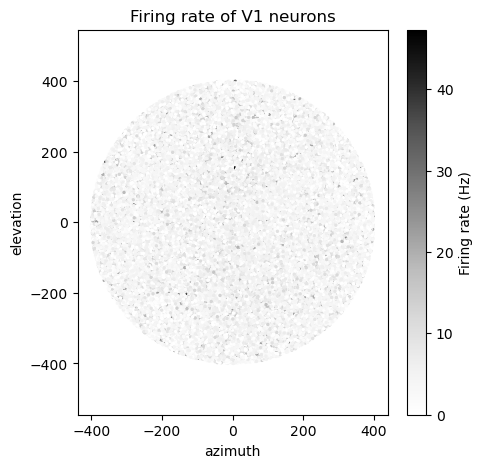

In [6]:
# Obtain the position of each V1 neuron
# Load model
cache_path = '/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/.cache/lm_v1_network_v1_100000_lm_30000.pkl'
with open(cache_path, 'rb') as f:
    networks, lgn_inputs, bkg_inputs = pkl.load(f)

# # filter only network in the core (radius < 400 mm)
# selected_mask = other_billeh_utils.isolate_core_neurons(networks, radius = 400, data_dir = '/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
# core_network = network[selected_mask]

# in networks['v1'] 'x' and 'z' are the 2 radial coordinates, and y is the depth in the column which I don't need
v1_positions_x = np.array(networks['v1']['x'])
v1_positions_z = np.array(networks['v1']['z'])

# filter only core neurons that follow r = np.sqrt(x ** 2 + z ** 2) < 400
r = np.sqrt(v1_positions_x ** 2 + v1_positions_z ** 2)
selected_mask = r < 400
v1_positions_x_core = v1_positions_x[selected_mask]
v1_positions_z_core = v1_positions_z[selected_mask]

# based on the histogram, make the maximum firing rate 0.01, so that any number larger is set to that value
# v1_mean_firing_rate[v1_mean_firing_rate > 0.01] = 0.01

# # Plot the 2D histogram of the firing rate of each neuron in V1 and their position in visual space
plt.figure(figsize=(5, 5))
plt.scatter(v1_positions_x_core, v1_positions_z_core, c=v1_mean_firing_rate*1000, cmap='Greys', s=2)
cbar = plt.colorbar()
cbar.set_label('Firing rate (Hz)')
plt.xlabel('azimuth')
plt.ylabel('elevation')	
# put axis in same scale
plt.axis('equal')
plt.title('Firing rate of V1 neurons')
plt.show()

Text(0.5, 1.0, 'Histogram of the firing rate of V1 neurons')

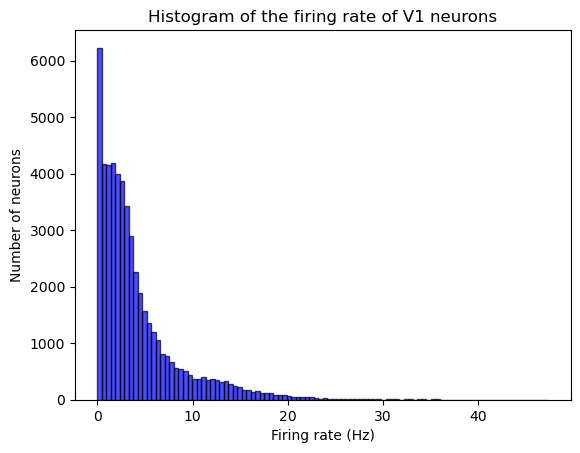

In [7]:
# Plot a histogram of v1_mean_firing_rate
plt.figure()
plt.hist(v1_mean_firing_rate*1000, bins=100, color='blue', alpha=0.7, label='V1', histtype='bar', edgecolor='black', 
         linewidth=1)
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Number of neurons')
plt.title('Histogram of the firing rate of V1 neurons')

In [8]:
# Now convert the scatter into a histogram where for each bin I compute the mean firing rate of the neurons in that bin
# Define the bins
from tqdm import tqdm

n_bins = 30

x_bins = np.linspace(-400, 400, n_bins)
z_bins = np.linspace(-400, 400, n_bins)

# Initialize a 2D array to hold the mean firing rate of the neurons in each bin
v1_firing_rate_bins = np.zeros((len(x_bins)-1, len(z_bins)-1))

# Loop over the bins
for i in tqdm(range(len(x_bins)-1)):
    for j in range(len(z_bins)-1):
        # Find the indices of the neurons in the bin
        indices = np.where((v1_positions_x_core >= x_bins[i]) & (v1_positions_x_core < x_bins[i+1]) & (v1_positions_z_core >= z_bins[j]) & (v1_positions_z_core < z_bins[j+1]))[0]
        
        # Compute the mean firing rate of the neurons in the bin
        if len(indices) > 0:
            v1_firing_rate_bins[i, j] = np.median(v1_mean_firing_rate[indices])

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [00:00<00:00, 435.59it/s]


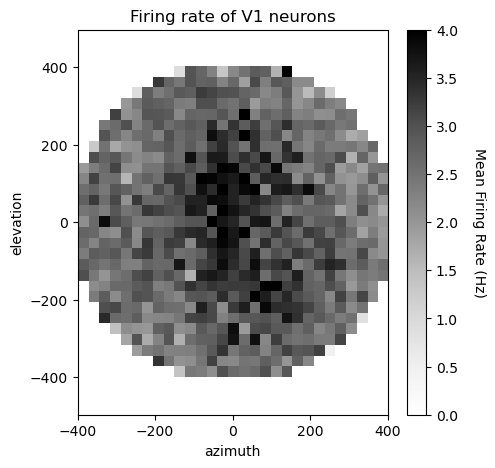

In [9]:
# Plot the 2D histogram
plt.figure(figsize=(5, 5))
plt.imshow(v1_firing_rate_bins.T*1000, extent=[-400, 400, -400, 400], origin='lower', cmap='Greys', vmax = 4)
cbar = plt.colorbar()
cbar.set_label('Mean Firing Rate (Hz)', rotation=270, labelpad=20)
plt.xlabel('azimuth')
plt.ylabel('elevation')
plt.title('Firing rate of V1 neurons')
plt.axis('equal')
plt.show()

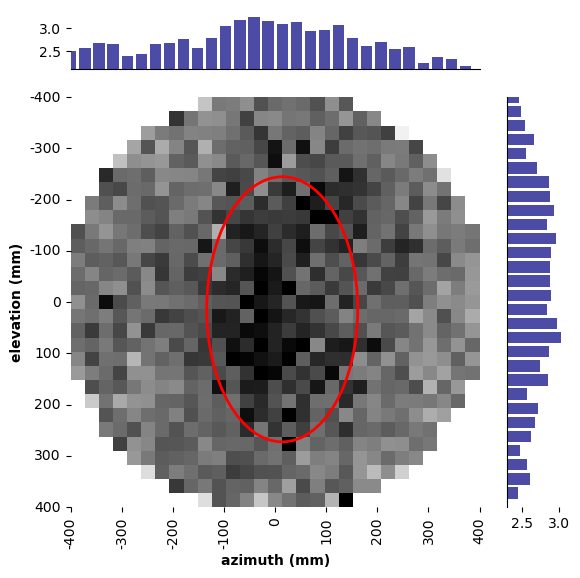

In [12]:
# Assuming v1_firing_rate_bins is a 2D numpy array
# Convert the 2D numpy array to a DataFrame
df = pd.DataFrame(v1_firing_rate_bins.T*1000)

# Define the dimensions
n_cols = df.shape[1]  # number of columns
n_rows = df.shape[0]  # number of rows

# Create a jointplot with histograms
g = sns.jointplot(x=np.tile(np.arange(n_cols), n_rows), y=np.repeat(np.arange(n_rows), n_cols), 
                  kind='hist', bins=(n_cols, n_rows)) # Create a jointplot
g.ax_marg_y.cla() # Clear the axes
g.ax_marg_x.cla() # Clear the axes 

sns.heatmap(data=df.to_numpy(), ax=g.ax_joint, cbar=False, cmap='Greys', vmax = 4)

# marginal bar plots
x = np.arange(n_cols)
non_zero_cols = np.count_nonzero(df, axis=0) # get number non-zero values per col/row
y_horizontal = np.array(np.sum(df, axis=0)) / non_zero_cols
y_vertical = np.array(np.sum(df, axis=1)) / non_zero_cols

g.ax_marg_x.bar(x, y_horizontal, color='navy', alpha=0.7, edgecolor='black', linewidth=0)
g.ax_marg_y.barh(x, y_vertical, color='navy', alpha=0.7, edgecolor='black', linewidth=0)
# add ylim
g.ax_marg_x.set_ylim(2.1, 3.4)
g.ax_marg_y.set_xlim(2.3, 3.1)

g.ax_joint.set_xlabel('azimuth (mm)', weight = 'bold')
g.ax_joint.set_ylabel('elevation (mm)', weight = 'bold')
# g.ax_joint.set_title('Firing rate of V1 neurons (Hz)')

# make xticks go from -400 to 400 
g.ax_joint.set_xticks(np.linspace(0, n_cols, 9))
g.ax_joint.set_xticklabels(np.linspace(-400, 400, 9).astype(int))
g.ax_joint.set_yticks(np.linspace(0, n_rows, 9))
g.ax_joint.set_yticklabels(np.linspace(-400, 400, 9).astype(int))

# Remove ticks showing the widths of the histograms
g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
# Remove ticks showing the heights of the histograms
#g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
#g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

# plot the following elipse on top of the heatmap centered
# at (0, 0) with a width of 200 and a height of 200
from matplotlib.patches import Ellipse
hor_axis = (20/70)*(30/800)*1000
ver_axis = (20/40)*(30/800)*1000
ellipse = Ellipse((15, 15), width=hor_axis, height=ver_axis, edgecolor='red', facecolor='none', lw=2)
g.ax_joint.add_patch(ellipse)


plt.tight_layout(pad = 1.5)

Text(0.5, 1.0, 'vertical sum of the heatmap')

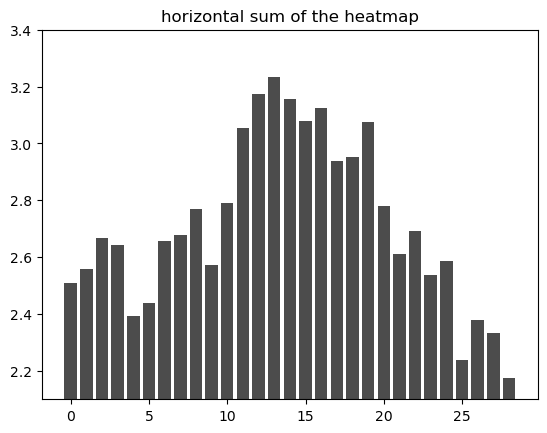

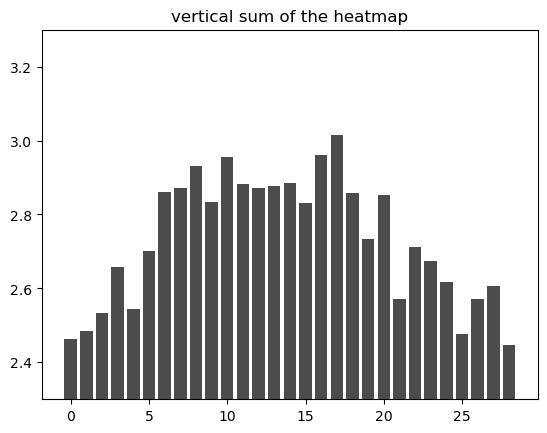

In [11]:
plt.figure()
plt.bar(x, y_horizontal, color='black', alpha=0.7)
plt.ylim([2.1, 3.4])
plt.title('horizontal sum of the heatmap')

plt.figure()
plt.bar(x, y_vertical, color='black', alpha=0.7)
plt.ylim([2.3, 3.3])
plt.title('vertical sum of the heatmap')


In [56]:
# Now do it again but selecting only neurons from a given type
# Create the neuron types mask
# obtain the neuron type of each neuron 
new_pop_names = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=51978, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
cell_types_v1 = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]

unique_cell_types = list(set(cell_types_v1))
unique_cell_types = sorted(unique_cell_types)

layer_mask_v1_types = [[cell_type == unique_cell_types[i] for cell_type in cell_types_v1] for i in range(len(unique_cell_types))]

# Apply the mask to mean firing rates AND positions
# Select the neuron type to filter
t = 1
type = unique_cell_types[t]
print("You have selected the type: ", type)

# Apply the mask to the mean firing rates
v1_mean_firing_rate_type = v1_mean_firing_rate[layer_mask_v1_types[t]]

# Apply the mask to the positions
v1_positions_x_core_type = v1_positions_x_core[layer_mask_v1_types[t]]
v1_positions_z_core_type = v1_positions_z_core[layer_mask_v1_types[t]]

You have selected the type:  L2/3 Exc


In [55]:
print(unique_cell_types)

['L1 Htr3a', 'L2/3 Exc', 'L2/3 Htr3a', 'L2/3 PV', 'L2/3 SST', 'L4 Exc', 'L4 Htr3a', 'L4 PV', 'L4 SST', 'L5 Exc', 'L5 Htr3a', 'L5 PV', 'L5 SST', 'L6 Exc', 'L6 Htr3a', 'L6 PV', 'L6 SST']


In [57]:
n_bins = 50
x_bins = np.linspace(-400, 400, n_bins)
z_bins = np.linspace(-400, 400, n_bins)

# Initialize a 2D array to hold the mean firing rate of the neurons in each bin
v1_firing_rate_bins = np.zeros((len(x_bins)-1, len(z_bins)-1))

# Loop over the bins
for i in tqdm(range(len(x_bins)-1)):
    for j in range(len(z_bins)-1):
        # Find the indices of the neurons in the bin
        indices = np.where((v1_positions_x_core_type >= x_bins[i]) & (v1_positions_x_core_type < x_bins[i+1]) & (v1_positions_z_core_type >= z_bins[j]) & (v1_positions_z_core_type < z_bins[j+1]))[0]
        
        # Compute the mean firing rate of the neurons in the bin
        if len(indices) > 0:
            v1_firing_rate_bins[i, j] = np.median(v1_mean_firing_rate_type[indices])

100%|██████████| 49/49 [00:00<00:00, 230.96it/s]


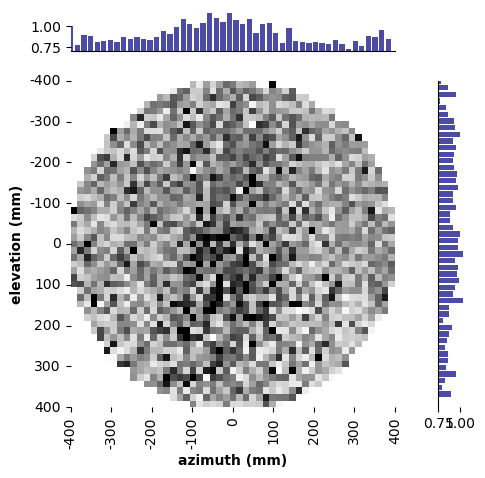

In [72]:
# Assuming v1_firing_rate_bins is a 2D numpy array
# Convert the 2D numpy array to a DataFrame
df = pd.DataFrame(v1_firing_rate_bins.T*1000)

# Define the dimensions
n_cols = df.shape[1]  # number of columns
n_rows = df.shape[0]  # number of rows

# Create a jointplot with histograms
g = sns.jointplot(x=np.tile(np.arange(n_cols), n_rows), y=np.repeat(np.arange(n_rows), n_cols), 
                  kind='hist', bins=(n_cols, n_rows), height=5, ratio=5) # Create a jointplot
g.ax_marg_y.cla() # Clear the axes
g.ax_marg_x.cla() # Clear the axes 

sns.heatmap(data=df.to_numpy(), ax=g.ax_joint, cbar=False, cmap='Greys', vmax = 1.75)

# marginal bar plots
x = np.arange(n_cols)

non_zero_cols = np.count_nonzero(df, axis=0) # get number non-zero values per col
non_zero_rows = np.count_nonzero(df, axis=1) # get number non-zero values per row
y_horizontal = np.array(np.sum(df, axis=0)) / non_zero_cols
y_vertical = np.array(np.sum(df, axis=1)) / non_zero_rows

g.ax_marg_x.bar(x, y_horizontal, color='navy', alpha=0.7, edgecolor='black', linewidth=0)
g.ax_marg_y.barh(x, y_vertical, color='navy', alpha=0.7, edgecolor='black', linewidth=0)
# add ylim
g.ax_marg_x.set_ylim(0.7, 1.2)
g.ax_marg_y.set_xlim(0.75, 1.1)

g.ax_joint.set_xlabel('azimuth (mm)', weight = 'bold')
g.ax_joint.set_ylabel('elevation (mm)', weight = 'bold')
# g.ax_joint.set_title('Firing rate of V1 neurons (Hz)')

# make xticks go from -400 to 400 
g.ax_joint.set_xticks(np.linspace(0, n_cols, 9))
g.ax_joint.set_xticklabels(np.linspace(-400, 400, 9).astype(int))
g.ax_joint.set_yticks(np.linspace(0, n_rows, 9))
g.ax_joint.set_yticklabels(np.linspace(-400, 400, 9).astype(int))

# Remove ticks showing the widths of the histograms
g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
# Remove ticks showing the heights of the histograms
#g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
#g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)



plt.tight_layout(pad = 1.5)

In [21]:
# y lims for different cell types to get better plots
# L4 Htr3a: h[2,4], v[2,3.6]
# L4 Exc: h[2.3, 3.5], v[2.3, 3.4]
# L5 Exc: h[4.2, 6.75], v[4.4, 6.25]
# L6 Exc: h[2, 4.2], v[2.5, 3.8]
# L2/3 Exc: h[0.7, 1.2], v[0.75, 1.1]

Text(0.5, 1.0, 'vertical sum of the heatmap')

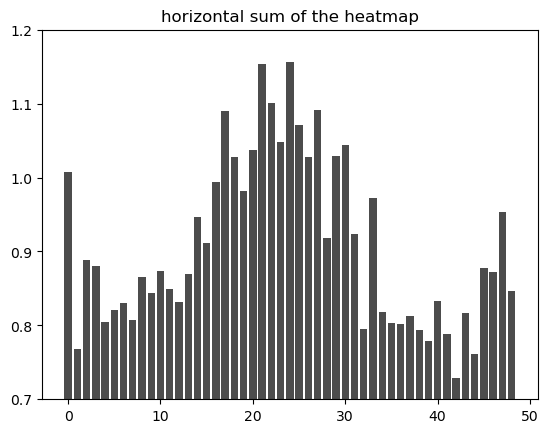

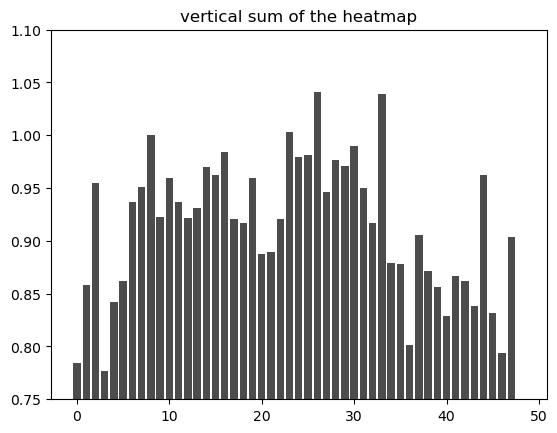

In [71]:
plt.figure()
plt.bar(x, y_horizontal, color='black', alpha=0.7)
plt.ylim([0.7, 1.2])
plt.title('horizontal sum of the heatmap')

plt.figure()
plt.bar(x, y_vertical, color='black', alpha=0.7)
plt.ylim([0.75, 1.1])
plt.title('vertical sum of the heatmap')